### Loading the Cleaned Dataset

In [1]:
import pandas as pd

# Load safely
df_stack = pd.read_csv(
    "stack_overflow_cleaned.csv",
    on_bad_lines='skip',
    encoding='utf-8',
    low_memory=False
)

# compare with a "raw line count"
!wc -l /content/stack_overflow_cleaned.csv  # Unix: count original lines in file
print("Rows after load:", df_stack.shape[0])

Rows after load: 11341


'wc' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
df_stack.dtypes

Age                                object
Employment                         object
RemoteWork                         object
EdLevel                            object
LearnCodeCoursesCert               object
YearsCode                         float64
YearsCodePro                      float64
DevType                            object
OrgSize                            object
CompTotal                         float64
LanguageHaveWorkedWith             object
DatabaseHaveWorkedWith             object
PlatformHaveWorkedWith             object
WebframeHaveWorkedWith             object
MiscTechHaveWorkedWith             object
ToolsTechHaveWorkedWith            object
NEWCollabToolsHaveWorkedWith       object
OpSysPersonal use                  object
OpSysProfessional use              object
OfficeStackAsyncHaveWorkedWith     object
OfficeStackSyncHaveWorkedWith      object
AISearchHaveWorkedWith             object
AISelect                           object
AIToolCurrently Using             

### Addressing Outliers in CompTotal (Target Variable)

**Strategy**

* We use `describe()` function with high percentiles (.90 to .999), in order to examine the upper distribution of the target variable `CompTotal`.

* This help us identify extreme salary values that may skew model training.

In [3]:
# Filter out unrealistic or extreme salary values from CompTotal
# This helps us understand the distribution of salary values,
# especially the extreme upper percentiles (90th–99.9th)
# Used to justify a statistically sound salary cap (e.g., 500k based on 99th percentile)

df_stack["CompTotal"].describe(percentiles=[.90, .95, .99, .995, .999])

count    1.134100e+04
mean     8.817566e+11
std      9.390189e+13
min      0.000000e+00
50%      1.500000e+05
90%      2.600000e+05
95%      3.330000e+05
99%      5.500000e+05
99.5%    7.500000e+05
99.9%    1.300000e+06
max      1.000000e+16
Name: CompTotal, dtype: float64

**Observations**

* Based on the results,
    * Median salary (50%) is 150,000.
    * 90th percentile is 260k and 99th percentile is 550k.
    * Meanwhile, 99.9th percentile is double the amount at 1.3 mil.
    * Max salary recorded is 10 trillion, which is definitely an anomaly.
    * Min salary recorded is 0, which also doesn't make sense.
* To reduce the influence of some of the unrealistic salaries, we are going to retain the data points with `CompTotal` between **$5,000** and **$500,000**.
* This way, we can filter out noise and ensure more stable regression performance.

**Strategy**

We filtered `df_stack` to keep only rows where `CompTotal` is `>= 5000` and `<= 500000`.

* We used `df_stack["CompTotal"] >= 5000` to exclude rows with low or invalid salaries, like 0 or missing values.
* We used `df_stack["CompTotal"] <= 500000` to exclude rows with unrealistically high salaries like 1.3 mil or 10 trillions.
* We combined both conditions using the `&` operator and reassigned the filtered data back to `df_stack`.

In [4]:
# Filter out unrealistic salary values before modeling
# Keep only salaries between $5,000 and $500,000 to remove extreme outliers
# This ensures the target distribution is more suitable for regression

df_stack = df_stack[(df_stack["CompTotal"] >= 5000) & (df_stack["CompTotal"] <= 500000)]

## Visualize skewness of raw and log-transformed salary values

**Strategy**

We compared the skewness of `CompTotal` before and after log transformation to assess whether normalization would improve model performance.

* We used `df_stack["CompTotal"].skew()` to check the original skew. It returned 1.43, meaning it is a strong positive (right) skew.

* Then we applied `np.log1p` to the target `df_stack["CompTotal"]`, and checked the skewness as well. It returned -0.52, meaning it is a more balanced distribution, with a slight left skew.

* We also plotted both raw and log-transformed target histograms using `plt.hist()` to visually compare the skewness.

In [5]:
import numpy as np

# Compare skewness of raw and log-transformed salary values
# Raw skew helps us see the original distribution shape
# Log-transformed skew helps assess if normalization is beneficial for modeling
raw_skew = df_stack["CompTotal"].skew()
log_skew = np.log1p(df_stack["CompTotal"]).skew()

# Print both for interpretation before deciding on the final target
print(f"Raw CompTotal skew: {raw_skew:.2f}")
print(f"Log-transformed skew: {log_skew:.2f}")

Raw CompTotal skew: 1.43
Log-transformed skew: -0.52


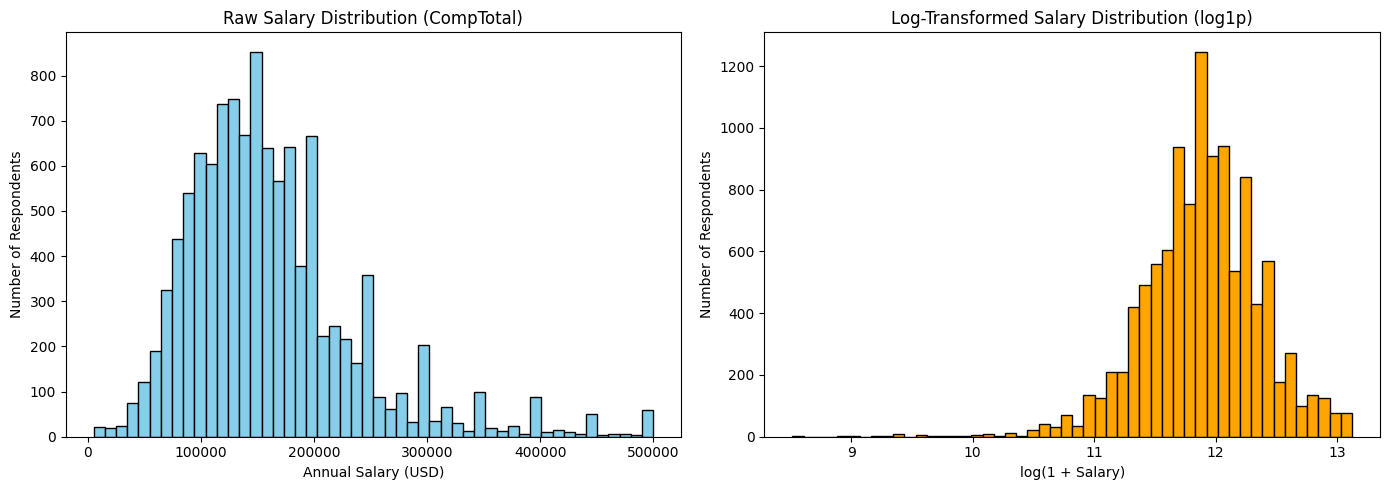

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# TEMP log transform (won't affect the DataFrame)
log_salaries = np.log1p(df_stack["CompTotal"])

plt.figure(figsize=(14, 5))

# Raw salary histogram
plt.subplot(1, 2, 1)
plt.hist(df_stack["CompTotal"], bins=50, color='skyblue', edgecolor='black')
plt.title("Raw Salary Distribution (CompTotal)")
plt.xlabel("Annual Salary (USD)")
plt.ylabel("Number of Respondents")

# Log-transformed salary histogram
plt.subplot(1, 2, 2)
plt.hist(log_salaries, bins=50, color='orange', edgecolor='black')
plt.title("Log-Transformed Salary Distribution (log1p)")
plt.xlabel("log(1 + Salary)")
plt.ylabel("Number of Respondents")

plt.tight_layout()
plt.show()


**Observations**

* The left plot shows the skewed distribution of raw `CompTotal` values. The right plot shows a more normalized shape after applying `log1p()`.

* We observed that the raw target had a skew of 1.43, while the log-transformed version had a reduced skew of –0.52.

* To evaluate which version is better for modeling, we plan to train models using both the raw and log-transformed targets.

* This comparison will help us determine whether the log-transformed target leads to more stable and accurate predictions.

# Feature Engineering

Our goal is to build a strong, simple baseline model.

**Feature Encoding Strategy**

* We started with a cleaned dataset of 11,111 rows and 188 features.

* Before encoding, we checked the cardinality of all object-type columns using `df_stack[cat_cols].nunique()`.

* This helped us identify:

  * High-cardinality columns (e.g., `LanguageHaveWorkedWith`, `DatabaseHaveWorkedWith`) that require special handling
  * Low-cardinality columns (e.g., `EdLevel`, `OrgSize`, `RemoteWork`) that are safe to one-hot encode
  * Columns we may need to drop or group due to excessive sparsity or noise

* We applied one-hot encoding only to a selected group of relevant categorical features to:

  * Avoid exploding the feature space
  * Keep the dataset manageable
  * Reduce model complexity

* Our goal was to build a cleaner, more efficient model by encoding only what truly influences salary.

### Checking cardinality

In [7]:
# Identify all object columns
cat_cols = df_stack.select_dtypes(include='object').columns

# Count the number of unique values in each cat col
cardinality_counts = df_stack[cat_cols].nunique().sort_values(ascending=False)

# Display the result
print("Cardinality of categorical columns:")
display(cardinality_counts)

Cardinality of categorical columns:


ToolsTechHaveWorkedWith           6153
LanguageHaveWorkedWith            5967
NEWCollabToolsHaveWorkedWith      3614
WebframeHaveWorkedWith            3109
DatabaseHaveWorkedWith            2607
MiscTechHaveWorkedWith            1883
OfficeStackAsyncHaveWorkedWith    1835
OfficeStackSyncHaveWorkedWith     1584
PlatformHaveWorkedWith            1316
OpSysPersonal use                  959
OpSysProfessional use              756
AIToolCurrently Using              221
LearnCodeCoursesCert               156
AISearchHaveWorkedWith             102
DevType                             33
Employment                          13
Industry                            12
OrgSize                             11
Age                                  8
EdLevel                              8
Knowledge_8                          5
Knowledge_2                          5
Knowledge_3                          5
Knowledge_4                          5
Knowledge_5                          5
Knowledge_1              

**Observations**

Based on the cardinality summary of categorical features, we can now define our encoding strategy since we already identified the number of unique values in each categorical column.

* Low-cardinality features such as `EdLevel`, `Employment`, `RemoteWork`, `DevType`, and `OrgSize` have fewer than 50 unique values. These are suitable for one-hot or ordinal encoding.

* High-cardinality features include multi-select tech stack columns like `LanguageHaveWorkedWith`, `DatabaseHaveWorkedWith`, and `ToolsTechHaveWorkedWith`, which contain hundreds to thousands of unique entries. For these, we plan to apply custom multi-label encoding using top-N selections, due to their high dimensionality and sparsity.

This approach helps us avoid unnecessary feature explosion and supports an encoding strategy that balances coverage, interpretability, and model efficiency.

### Encoding EdLevel

**Strategy**

* First, we will start with `EdLevel`.

* To prepare EdLevel for modeling, we first checked the column for missing or invalid entries:

    * We used `.isna().sum()` to confirm that there were no NaN values.

    * Then applied `.str.strip()` and compared against "" to detect blank or whitespace-only strings.

* Both checks returned zero, so no cleaning was needed in that regard.

* We also double checked the unique values using `.unique()` since we standardized and cleaned the inputs in previous notebook.

In [8]:
# Check for actual NaN values to be sure
nan_count = df_stack["EdLevel"].isna().sum()

# Check for empty strings or strings with only whitespace
blank_count = (df_stack["EdLevel"].str.strip() == "").sum()

print(f"NaN count in EdLevel: {nan_count}")
print(f"Blank/whitespace-only count in EdLevel: {blank_count}")

NaN count in EdLevel: 0
Blank/whitespace-only count in EdLevel: 0


In [9]:
# Double Check the Unique values of EdLevel
print(df_stack['EdLevel'].unique())

["Bachelor's degree"
 'Some college/university study without earning a degree'
 "Master's degree" 'Professional degree' 'Secondary school'
 'Associate degree' 'Something else' 'Primary/elementary school']


**Strategy**

Since education levels follow an inherent ordinal structure, we used ordinal encoding to preserve that progression for modeling.

* First, we cleaned up the text format by applying `str.strip()` to remove any leading or trailing whitespace in the `EdLevel` column.

* Next, we defined an ordinal mapping `ed_map` that assigned increasing numeric values to reflect education levels. It starts from `Primary/elementary school` (0) to `Professional degree` (6). We mapped `"Something else"` to `np.nan` so that it would be treated as unknown during modeling.

* Then, we applied the mapping using `.map(ed_map)` and saved the result in a new column called `EdLevel_encoded`.

* After that, we used `.drop_duplicates()` to visually confirm that the encoding was applied as expected and the values aligned correctly.

This way, we preserved the natural educational hierarchy in the data. It helps the model interpret progression in education and handles ambiguous entries safely.

In [10]:
import numpy as np

# Step 1 – Strip and standardize EdLevel
df_stack["EdLevel"] = df_stack["EdLevel"].str.strip()

# Step 2 – Define ordinal mapping
ed_map = {
    "Primary/elementary school": 0,
    "Secondary school": 1,
    "Some college/university study without earning a degree": 2,
    "Associate degree": 3,
    "Bachelor's degree": 4,
    "Master's degree": 5,
    "Professional degree": 6,
    "Something else": np.nan  # we'll treat this as unknown
}

# Step 3 – Apply mapping
df_stack["EdLevel_encoded"] = df_stack["EdLevel"].map(ed_map)

# Step 4 – Inspect
print(df_stack[["EdLevel", "EdLevel_encoded"]].drop_duplicates())

                                               EdLevel  EdLevel_encoded
0                                    Bachelor's degree              4.0
3    Some college/university study without earning ...              2.0
6                                      Master's degree              5.0
27                                 Professional degree              6.0
38                                    Secondary school              1.0
39                                    Associate degree              3.0
71                                      Something else              NaN
133                          Primary/elementary school              0.0


In [11]:
# Drop original column
df_stack.drop(['EdLevel'], axis=1, inplace=True)

**Observations**

* Based on the results, we can see that ordinal encoding was applied correctly:

  * `"Primary/elementary school"` is encoded as **0**
  * `"Secondary school"` as **1**
  * `"Some college/university study without earning a degree"` as **2**
  * `"Associate degree"` as **3**
  * `"Bachelor's degree"` as **4**
  * `"Master's degree"` as **5**
  * `"Professional degree"` as **6**

* The value `"Something else"` was intentionally mapped to `NaN` to represent unknown education level.

### Encoding Employment

**Strategy**

* `Employment` column allows multiple selections like "Employed full-time", "Self-employed", etc., so we need to break these out into a structure that the model can learn from.

* This type of transformation is known as **multi-label binary encoding**, where each possible option becomes a separate `True/False` column.

* To start, we need to fill missing values with an empty string using `.fillna("")` so we can safely split the entries in the next step without causing errors.

* Then we need to split the string on semicolons (;) to isolate each selected option. During this step, we also need to remove extra spaces and standardize the case using `.strip()` and `.lower()`.

* Once everything is cleaned, we need to create new binary columns for each key employment status:

  * `is_full_time`: True if the person selected "Employed, full-time"
  * `is_part_time`: True if "Employed, part-time"
  * `is_self_employed`: True if "Independent contractor, freelancer, or self-employed"
  * `is_retired`: True if "Retired"

* We also need to add `is_employment_unspecified` to capture cases where the respondent chose not to answer.

* This will let us keep all relevant employment types as separate signals in the model without losing any information in the process.

In [12]:
print(df_stack["Employment"].unique())

['Employed, full-time'
 'Independent contractor, freelancer, or self-employed'
 'Employed, part-time'
 'Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time'
 'Employed, full-time;Independent contractor, freelancer, or self-employed'
 'Employed, full-time;Employed, part-time' 'I prefer not to say'
 'Independent contractor, freelancer, or self-employed;Retired'
 'Independent contractor, freelancer, or self-employed;Employed, part-time'
 'Independent contractor, freelancer, or self-employed;Employed, part-time;Retired'
 nan 'Employed, full-time;Retired'
 'Employed, full-time;Independent contractor, freelancer, or self-employed;Retired'
 'Retired']


In [13]:
# Step 1: Fill NaN with empty string so we can split safely
df_stack["Employment_clean"] = df_stack["Employment"].fillna("")

# Step 2: Split on ';' and normalize
df_stack["Employment_clean"] = df_stack["Employment_clean"].str.split(";").apply(
    lambda items: [item.strip().lower() for item in items]
)

# Step 3: Create binary indicator columns
df_stack["is_full_time"] = df_stack["Employment_clean"].apply(lambda x: "employed, full-time" in x)
df_stack["is_part_time"] = df_stack["Employment_clean"].apply(lambda x: "employed, part-time" in x)
df_stack["is_self_employed"] = df_stack["Employment_clean"].apply(lambda x: "independent contractor, freelancer, or self-employed" in x)
df_stack["is_retired"] = df_stack["Employment_clean"].apply(lambda x: "retired" in x)

# Flag if respondent didn't want to say
df_stack["is_employment_unspecified"] = df_stack["Employment_clean"].apply(lambda x: "i prefer not to say" in x)

In [14]:
# Show a sample of the cleaned columns
cols_to_show = ["Employment", "Employment_clean", "is_full_time", "is_part_time", "is_self_employed", "is_retired", "is_employment_unspecified"]
print(df_stack[cols_to_show].head(10))

            Employment       Employment_clean  is_full_time  is_part_time  \
0  Employed, full-time  [employed, full-time]          True         False   
1  Employed, full-time  [employed, full-time]          True         False   
2  Employed, full-time  [employed, full-time]          True         False   
3  Employed, full-time  [employed, full-time]          True         False   
4  Employed, full-time  [employed, full-time]          True         False   
5  Employed, full-time  [employed, full-time]          True         False   
6  Employed, full-time  [employed, full-time]          True         False   
7  Employed, full-time  [employed, full-time]          True         False   
8  Employed, full-time  [employed, full-time]          True         False   
9  Employed, full-time  [employed, full-time]          True         False   

   is_self_employed  is_retired  is_employment_unspecified  
0             False       False                      False  
1             False       Fals

In [15]:
# Drop original and _clean columns
df_stack.drop(['Employment', 'Employment_clean'], axis=1, inplace=True)

**Observations**

Based on the 10 sample records, we can confirm that the multi-label encoding logic worked as expected.
* The `Employment_clean` column correctly shows a normalized list: `["employed, full-time"]`.
* Only `is_full_time` flag is marked as `True`, whereas all other flags (`is_part_time`, `is_self_employed`, `is_retired`) are `False`.
* The `is_employment_unspecified` flag is also `False`, which is accurate since a clear response (i.e. employed, full-time) was provided.

### Encoding RemoteWork

**Strategy**

* `RemoteWork` column includes mutually exclusive responses like "Remote", "Hybrid (some remote, some in-person)", and "In-person", so we need to break these out into separate binary flags to make this usable in modeling.

* First, we need to clean the column by filling missing values with an empty string using `.fillna("")`, then standardize the text using `.str.strip().str.lower()`.

* Once everything is cleaned, we need to create new binary columns for each remote work type:

  * `is_remote`: True if the respondent selected "Remote"
  * `is_hybrid`: True if "Hybrid (some remote, some in-person)"
  * `is_inperson`: True if "In-person"

* This will allow us to retain each remote work preference as an individual feature the model can learn from.

In [16]:
print(df_stack["RemoteWork"].unique())

['Remote' 'Hybrid (some remote, some in-person)' 'In-person' nan]


In [17]:
# Step 1: Fill NA and standardize case
df_stack["RemoteWork_clean"] = df_stack["RemoteWork"].fillna("").str.strip().str.lower()

# Step 2: Create binary flags
df_stack["is_remote"] = df_stack["RemoteWork_clean"] == "remote"
df_stack["is_hybrid"] = df_stack["RemoteWork_clean"] == "hybrid (some remote, some in-person)"
df_stack["is_inperson"] = df_stack["RemoteWork_clean"] == "in-person"

# Step 3: Inspect a few rows
cols_to_show = ["RemoteWork", "RemoteWork_clean", "is_remote", "is_hybrid", "is_inperson"]
print(df_stack[cols_to_show].head(10))

                             RemoteWork                      RemoteWork_clean  \
0                                Remote                                remote   
1  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   
2  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   
3                                Remote                                remote   
4                                Remote                                remote   
5                                Remote                                remote   
6  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   
7  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   
8                                Remote                                remote   
9  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   

   is_remote  is_hybrid  is_inperson  
0       True      False        False  
1      False       True       

In [18]:
# Drop original and _clean columns
df_stack.drop(['RemoteWork', 'RemoteWork_clean'], axis=1, inplace=True)

**Observations**

Based on the 10 sample records, we can confirm that the binary encoding logic worked as intended for remote work preferences.

* The `RemoteWork_clean` column shows correctly standardized values like `"remote"` and `"hybrid (some remote, some in-person)"`.
* The `is_remote` flag is `True` only when the response is "Remote".
* The `is_hybrid` flag is `True` only for hybrid work arrangements.
* The `is_inperson` flag remains `False` across all rows, which makes sense as no one in this subset selected "In-person".

### Encode DevType

**Strategy**

* `DevType` column contains multiple roles per respondent (e.g., “Developer, full-stack; Developer, back-end”), so we need to convert this into a model-friendly format.

* To handle this, we need to do **multi-label one-hot encoding**.

* First, we fill missing values with an empty string using `.fillna("")` to avoid issues during string operations.

* Then we split the text on semicolons (`;`) to extract each individual role. At the same time, we normalize the format using `.strip()` and `.lower()` to remove excess spaces and unify casing.

* Since there are over 20 unique roles, we reduce dimensionality by keeping only the top 10 most frequent ones based on our earlier EDA in previous notebook.

* Finally, we apply one-hot encoding manually:

  * For each of the top 10 roles, we create a binary column using a `for` loop and a `lambda` function to flag whether the role appears in a respondent's list.
  * We also reformat column names by replacing characters like commas and spaces to keep them clean.

* This way, we capture relevant role information while keeping the feature space compact.

In [19]:
print(df_stack["DevType"].unique())

['Senior Executive (C-Suite, VP, etc.)' 'Developer, back-end'
 'Developer, front-end' 'Developer, full-stack' 'Developer, QA or test'
 'System administrator' 'Database administrator'
 'Developer, desktop or enterprise applications'
 'Data or business analyst' 'Cloud infrastructure engineer'
 'Engineering manager' 'Other (please specify):' 'Developer Experience'
 'Data scientist or machine learning specialist' 'Developer, mobile'
 'Engineer, data' 'Academic researcher'
 'Developer, embedded applications or devices' 'Developer Advocate'
 'Project manager' 'Security professional' 'Hardware Engineer'
 'Developer, game or graphics' 'Product manager' 'DevOps specialist'
 'Research & Development role' 'Engineer, site reliability' 'Designer'
 'Blockchain' 'Scientist' nan 'Marketing or sales professional' 'Educator'
 'Student']


**Since we have a lot of unique values for DevType, we will use the TOP 10 Dev from the EDA**

In [20]:
# Fill NaNs and split roles into list
df_stack["DevType_clean"] = df_stack["DevType"].fillna("").apply(
    lambda x: [role.strip() for role in x.split(";")]
)

top_10_roles = [
    'Developer, full-stack',
    'Developer, back-end',
    'Developer, front-end',
    'Developer, desktop or enterprise applications',
    'Engineering manager',
    'Other (please specify):',
    'Developer, embedded applications or devices',
    'Developer, mobile',
    'Cloud infrastructure engineer',
    'Data scientist or machine learning specialist'
]

# Create one-hot (binary) columns for each top role
for role in top_10_roles:
    col_name = f"is_{role.lower().replace(',', '').replace(' ', '_').replace('-', '_')}"
    df_stack[col_name] = df_stack["DevType_clean"].apply(lambda roles: role in roles)

# Show the sample
cols_to_show = ["DevType"] + [f"is_{role.lower().replace(',', '').replace(' ', '_').replace('-', '_')}" for role in top_10_roles]
df_stack[cols_to_show].head(10)

,DevType,is_developer_full_stack,is_developer_back_end,is_developer_front_end,is_developer_desktop_or_enterprise_applications,is_engineering_manager,is_other_(please_specify):,is_developer_embedded_applications_or_devices,is_developer_mobile,is_cloud_infrastructure_engineer,is_data_scientist_or_machine_learning_specialist
0,"Senior Executive (C-Suite, VP, etc.)",False,False,False,False,False,False,False,False,False,False
1,"Developer, back-end",False,True,False,False,False,False,False,False,False,False
2,"Developer, front-end",False,False,True,False,False,False,False,False,False,False
3,"Developer, full-stack",True,False,False,False,False,False,False,False,False,False
4,"Developer, full-stack",True,False,False,False,False,False,False,False,False,False
5,"Developer, full-stack",True,False,False,False,False,False,False,False,False,False
6,"Developer, QA or test",False,False,False,False,False,False,False,False,False,False
7,"Developer, full-stack",True,False,False,False,False,False,False,False,False,False
8,"Developer, front-end",False,False,True,False,False,False,False,False,False,False
9,System administrator,False,False,False,False,False,False,False,False,False,False


In [21]:
df_stack.rename(columns={
    'is_other_(please_specify):': 'is_other_please_specify'
}, inplace=True)

In [22]:
# Drop original and _clean columns
df_stack.drop(['DevType', 'DevType_clean'], axis=1, inplace=True)

**Observations**

Based on the 10 sample records, we can confirm that the custom one-hot encoding logic for `DevType` worked as intended.

* Each row correctly flags whether a respondent holds one of the top 10 developer roles identified during EDA.
* For example, records 3, 4, 5, and 7 are marked as `True` for `is_developer_full_stack`, while all other flags remain `False`.
* Roles not included in the top 10 list, like "Senior Executive", "QA or test", and "System administrator", are correctly left with all indicators set to `False`.

This shows that only the top roles we picked are flagged, and everything else is left out as expected.

### Encoding OrgSize

**Strategy**

* `OrgSize` column describes company size using predefined ranges like "1-9", "100-499", and "10,000 or more", which follow a natural increasing order. Because of that, we need to apply **ordinal encoding** instead of one-hot encoding.

* To start, we define a custom dictionary to map each size range to an increasing integer (e.g., 0 for freelancers, 8 for the largest organizations). Variations like `"2-9"` and `"1-9"` are grouped under the same value since these are overlapped.

* We also include `"I don't know"` responses in the mapping and treat them as missing by assigning `np.nan`.

* Then we apply this mapping using `.map(orgsize_map)` and store the result in a new column called `OrgSize_encoded`.

* This way, we can preserve the natural order of organization sizes, so the model can learn from their progression while ignoring unclear entries.

In [23]:
# Step 1: Inspect unique values
print(df_stack["OrgSize"].unique())

['2-9' '5,000-9,999' '100-499' '1,000-4,999' '10-19' '10,000 or more'
 '500-999' '20-99' 'Just me - I am a freelancer, sole proprietor, etc.'
 "I don't know" 'I don’t know' nan]


In [24]:
# Step 2: Define ordinal mapping for OrgSize
orgsize_map = {
    "Just me - I am a freelancer, sole proprietor, etc.": 0,
    "1-9": 1,
    "2-9": 1,  # handling possible variations
    "10-19": 2,
    "20-99": 3,
    "100-499": 4,
    "500-999": 5,
    "1,000-4,999": 6,
    "5,000-9,999": 7,
    "10,000 or more": 8,
    "I don't know": np.nan  # treat "don't know" as missing
}

# Step 3: Apply the mapping
df_stack["OrgSize_encoded"] = df_stack["OrgSize"].map(orgsize_map)

# Step 4: Inspect results
print(df_stack[["OrgSize", "OrgSize_encoded"]].drop_duplicates())

                                                OrgSize  OrgSize_encoded
0                                                   2-9              1.0
1                                           5,000-9,999              7.0
2                                               100-499              4.0
3                                           1,000-4,999              6.0
4                                                 10-19              2.0
6                                        10,000 or more              8.0
12                                              500-999              5.0
21                                                20-99              3.0
22    Just me - I am a freelancer, sole proprietor, ...              0.0
117                                        I don't know              NaN
986                                        I don’t know              NaN
4868                                                NaN              NaN


In [25]:
# Drop original column
df_stack.drop(['OrgSize'], axis=1, inplace=True)

**Observations**

Based on the results, we can see that ordinal encoding was applied correctly:

* Smaller ranges like `"2-9"` and `"10-19"` are mapped to lower integers (1 and 2), while larger ones like `"5,000-9,999"` and `"10,000 or more"` are mapped to higher values (7 and 8).
* `"Just me"` (freelancer) is correctly mapped to `0`, representing the smallest organizational size.
* Ambiguous responses like `"I don't know"` or missing values (`NaN`) remain unencoded as `NaN`, which is intentional and ensures these won't interfere with ordinal learning.

For `NaN` values, we will keep them for now and handle them at a later preprocessing step.

### One-Hot Encoding Multi-Select Tech Stack Columns

**Strategy**

* In the dataset, we have other multi-select fields like `LanguageHaveWorkedWith`, `DatabaseHaveWorkedWith`, and `PlatformHaveWorkedWith`, where respondents could choose multiple tools or technologies, similar what we encountered earlier like `DevType` column.

* To prepare these for modeling, we need to convert them into binary indicator columns for the most relevant technologies/tools.

* To streamline this, we created a custom function called `process_multiselect_column()` that takes in `df`, `col_name`, and `top_n=10`.

* Inside this function:

  * First, we fill missing values using `.fillna("")`, split the text by semicolon `;`, and strip whitespace. This gives us a clean list of selected technology/tool per respondent.
  * Then, we flatten all the responses and use `collections.Counter` to rank frequency. From there, we extract the top N technologies/tools.
  * For each top N technology/tool, we create a binary column using `.apply(lambda x: item in x)`. We also clean the column names using `.replace()` to remove symbols and spaces.

* This way, we can reuse the same logic across different columns.

In [26]:
from collections import Counter

def process_multiselect_column(df_stack, col_name, top_n=10):
    # Normalize column name for new column creation
    col_safe = col_name.replace(" ", "_")

    # Step 1: Clean and split
    clean_col = f"{col_safe}_clean"
    df_stack[clean_col] = df_stack[col_name].fillna("").apply(
        lambda x: [item.strip().lower() for item in x.split(";") if item.strip()]
    )

    # Step 2: Count top N items
    counter = Counter([item for sublist in df_stack[clean_col] for item in sublist])
    top_items = [item for item, _ in counter.most_common(top_n)]

    # Step 3: Create new one-hot encoded columns
    new_cols = {}
    for item in top_items:
        raw_name = item.lower()
        safe_col = (
            f"{col_safe}_{raw_name}"
            .replace(' ', '_')
            .replace('-', '_')
            .replace('+', '_')
            .replace('.', '')
            .replace(',', '')
            .replace('/', '_')
            .replace('(', '')
            .replace(')', '')
            .replace('[', '')
            .replace(']', '')
            .replace('{', '')
            .replace('}', '')
            .replace('&', 'and')
            .replace('#', 'sharp')
            .replace('*', '')
            .replace('%', '')
        )
        while '__' in safe_col:
            safe_col = safe_col.replace('__', '_')
        safe_col = safe_col.strip('_')

        new_cols[safe_col] = df_stack[clean_col].apply(lambda x: item in x)

    # Step 4: Merge new columns
    df_stack = pd.concat([df_stack, pd.DataFrame(new_cols, index=df_stack.index)], axis=1)
    df_stack = df_stack.copy()

    return top_items, df_stack

**Implementation**

* After defining the reusable `process_multiselect_column()` function, we applied it across all relevant multi-select columns.
* First we define `columns_to_process`. These include `LanguageHaveWorkedWith`, `DatabaseHaveWorkedWith`, `PlatformHaveWorkedWith`, etc.
* For each column, we extracted the top 10 most common values and created corresponding binary indicator columns using the function `process_multiselect_column`.
* After processing, we listed all generated binary columns per field using a simple loop and string matching.

In [27]:
# Define columns to process
columns_to_process = [
    'LanguageHaveWorkedWith',
    'DatabaseHaveWorkedWith',
    'PlatformHaveWorkedWith',
    'WebframeHaveWorkedWith',
    'MiscTechHaveWorkedWith',
    'ToolsTechHaveWorkedWith',
    'NEWCollabToolsHaveWorkedWith',
    'OpSysPersonal use',
    'OpSysProfessional use',
    'OfficeStackAsyncHaveWorkedWith',
    'OfficeStackSyncHaveWorkedWith',
    'AISearchHaveWorkedWith',
    'AIToolCurrently Using',
    'LearnCodeCoursesCert'
]

In [28]:
def preview_true_counts(df, col_name):
    """Return a Series counting number of items in each row of a multiselect column"""
    return df[col_name].fillna("").apply(
        lambda x: len([item.strip() for item in x.split(";") if item.strip()])
    )

count_stats = {}

for col in columns_to_process:
    if col in df_stack.columns:
        s = preview_true_counts(df_stack, col)
        count_stats[col] = {
            "mean": s.mean(),
            "min": s.min(),
            "max": s.max(),
            "nonzero_pct": (s > 0).mean() * 100
        }

# Show summary
pd.DataFrame(count_stats).T.round(1).sort_values("mean", ascending=False)

,mean,min,max,nonzero_pct
LanguageHaveWorkedWith,5.5,0.0,29.0,99.9
ToolsTechHaveWorkedWith,4.8,0.0,26.0,94.0
NEWCollabToolsHaveWorkedWith,3.3,0.0,23.0,99.5
OfficeStackSyncHaveWorkedWith,3.2,0.0,15.0,98.9
WebframeHaveWorkedWith,2.7,0.0,19.0,80.2
DatabaseHaveWorkedWith,2.5,0.0,18.0,87.9
OfficeStackAsyncHaveWorkedWith,2.4,0.0,16.0,89.4
OpSysPersonal use,2.1,0.0,18.0,99.3
OpSysProfessional use,1.8,0.0,18.0,94.4
PlatformHaveWorkedWith,1.8,0.0,13.0,83.0


In [29]:
for col in columns_to_process:
    new_col = f"num_{col.lower().replace(' ', '').replace('-', '_')}"
    df_stack[new_col] = df_stack[col].fillna("").apply(
        lambda x: len([item.strip() for item in x.split(";") if item.strip()])
    )

df_stack[[col for col in df_stack.columns if col.startswith("num_")]].head()

,num_languagehaveworkedwith,num_databasehaveworkedwith,num_platformhaveworkedwith,num_webframehaveworkedwith,num_misctechhaveworkedwith,num_toolstechhaveworkedwith,num_newcollabtoolshaveworkedwith,num_opsyspersonaluse,num_opsysprofessionaluse,num_officestackasynchaveworkedwith,num_officestacksynchaveworkedwith,num_aisearchhaveworkedwith,num_aitoolcurrentlyusing,num_learncodecoursescert
0,3,1,3,4,3,7,2,5,3,7,10,1,2,1
1,2,0,5,0,0,5,2,2,2,2,3,0,0,0
2,7,2,2,5,0,5,4,3,3,1,5,0,0,0
3,15,5,2,8,2,12,5,2,1,1,1,1,2,1
4,7,5,4,5,5,9,5,3,3,2,1,3,3,2


In [30]:
# Apply the function to each column
for col in columns_to_process:
    top_vals, df_stack = process_multiselect_column(df_stack, col, top_n=10)
    print(f"Processed {col}: {top_vals}")

Processed LanguageHaveWorkedWith: ['javascript', 'sql', 'html/css', 'python', 'typescript', 'bash/shell (all shells)', 'c#', 'java', 'powershell', 'c++']
Processed DatabaseHaveWorkedWith: ['postgresql', 'mysql', 'microsoft sql server', 'sqlite', 'redis', 'mongodb', 'elasticsearch', 'dynamodb', 'mariadb', 'oracle']
Processed PlatformHaveWorkedWith: ['amazon web services (aws)', 'microsoft azure', 'google cloud', 'cloudflare', 'digital ocean', 'heroku', 'firebase', 'vercel', 'netlify', 'vmware']
Processed WebframeHaveWorkedWith: ['react', 'node.js', 'jquery', 'asp.net core', 'angular', 'asp.net', 'express', 'next.js', 'vue.js', 'flask']
Processed MiscTechHaveWorkedWith: ['.net (5+)', '.net framework (1.0 - 4.8)', 'pandas', 'numpy', 'apache kafka', 'spring framework', 'rabbitmq', 'scikit-learn', 'react native', 'torch/pytorch']
Processed ToolsTechHaveWorkedWith: ['docker', 'npm', 'homebrew', 'pip', 'kubernetes', 'webpack', 'yarn', 'make', 'nuget', 'terraform']
Processed NEWCollabToolsHave

In [31]:
# Verify the columns
for col in columns_to_process:
    prefix = col.replace(" ", "_")  # Normalize to match actual column names
    matching_cols = [
        c for c in df_stack.columns
        if c.startswith(col.replace(" ", "_") + "_")
    ]
    print(f"{col} columns:", matching_cols)

LanguageHaveWorkedWith columns: ['LanguageHaveWorkedWith_clean', 'LanguageHaveWorkedWith_javascript', 'LanguageHaveWorkedWith_sql', 'LanguageHaveWorkedWith_html_css', 'LanguageHaveWorkedWith_python', 'LanguageHaveWorkedWith_typescript', 'LanguageHaveWorkedWith_bash_shell_all_shells', 'LanguageHaveWorkedWith_csharp', 'LanguageHaveWorkedWith_java', 'LanguageHaveWorkedWith_powershell', 'LanguageHaveWorkedWith_c']
DatabaseHaveWorkedWith columns: ['DatabaseHaveWorkedWith_clean', 'DatabaseHaveWorkedWith_postgresql', 'DatabaseHaveWorkedWith_mysql', 'DatabaseHaveWorkedWith_microsoft_sql_server', 'DatabaseHaveWorkedWith_sqlite', 'DatabaseHaveWorkedWith_redis', 'DatabaseHaveWorkedWith_mongodb', 'DatabaseHaveWorkedWith_elasticsearch', 'DatabaseHaveWorkedWith_dynamodb', 'DatabaseHaveWorkedWith_mariadb', 'DatabaseHaveWorkedWith_oracle']
PlatformHaveWorkedWith columns: ['PlatformHaveWorkedWith_clean', 'PlatformHaveWorkedWith_amazon_web_services_aws', 'PlatformHaveWorkedWith_microsoft_azure', 'Platfo

In [32]:
# Pick one processed column group to preview
example_col = "LanguageHaveWorkedWith"

# Print a few of the binary columns generated
print([col for col in df_stack.columns if col.startswith(example_col)])

# Display a few rows of just those columns
cols_to_show = [col for col in df_stack.columns if col.startswith(example_col)]
print(df_stack[cols_to_show].head(10).to_string(index=False))

['LanguageHaveWorkedWith', 'LanguageHaveWorkedWith_clean', 'LanguageHaveWorkedWith_javascript', 'LanguageHaveWorkedWith_sql', 'LanguageHaveWorkedWith_html_css', 'LanguageHaveWorkedWith_python', 'LanguageHaveWorkedWith_typescript', 'LanguageHaveWorkedWith_bash_shell_all_shells', 'LanguageHaveWorkedWith_csharp', 'LanguageHaveWorkedWith_java', 'LanguageHaveWorkedWith_powershell', 'LanguageHaveWorkedWith_c']
                                                                        LanguageHaveWorkedWith                                                                                   LanguageHaveWorkedWith_clean  LanguageHaveWorkedWith_javascript  LanguageHaveWorkedWith_sql  LanguageHaveWorkedWith_html_css  LanguageHaveWorkedWith_python  LanguageHaveWorkedWith_typescript  LanguageHaveWorkedWith_bash_shell_all_shells  LanguageHaveWorkedWith_csharp  LanguageHaveWorkedWith_java  LanguageHaveWorkedWith_powershell  LanguageHaveWorkedWith_c
                                                         

**Observations**

Based on the 10 sample rows, the one-hot encoding for `LanguageHaveWorkedWith` behaves as expected.

* Top 10 languages are correctly flagged per row.
* For example, record 0 shows `True` for `javascript`, `html_css`, and `python`.
* Less common languages are excluded as intended.

Next, we need to drop the original cols and _clean cols as we already did encoding.

### Dropping redundant columns

In [33]:
# Drop original and _clean versions of multi-select columns
cols_to_drop = []

for col in columns_to_process:
    col_safe = col.replace(" ", "_")
    cols_to_drop.append(col)
    cols_to_drop.append(f"{col_safe}_clean")

df_stack.drop(columns=cols_to_drop, inplace=True, errors='ignore')

### One-Hot Encoding remaining categorical cols

In [34]:
# Check if columns already exist
if not any(col.startswith("ai_usage_") for col in df_stack.columns):
    # Map the values
    df_stack["ai_usage_status"] = df_stack["AISelect"].map({
        "Yes": "currently_using",
        "No, but I plan to soon": "planning_to_use",
        "No, and I don't plan to": "not_using"
    }).fillna("unknown")
    
    # One-hot encode
    df_stack = pd.get_dummies(df_stack, columns=["ai_usage_status"], prefix="ai_usage", dtype=bool)
    
    # Drop one column to avoid multicollinearity
    df_stack = df_stack.drop('ai_usage_not_using', axis=1)

# Verify
print([col for col in df_stack.columns if col.startswith("ai_usage_")])

['ai_usage_currently_using', 'ai_usage_planning_to_use']


In [35]:
# Check if columns already exist
if not any(col.startswith("icorpm_") for col in df_stack.columns):
    # Fill missing values and clean
    df_stack["ICorPM_clean"] = df_stack["ICorPM"].fillna("unknown").str.strip().str.lower().str.replace(" ", "_")
    
    # One-hot encode
    df_stack = pd.get_dummies(df_stack, columns=["ICorPM_clean"], prefix="icorpm", dtype=bool)
    
    # Drop one column to avoid multicollinearity
    df_stack = df_stack.drop('icorpm_unknown', axis=1)

# Verify
print([col for col in df_stack.columns if col.startswith("icorpm_")])

['icorpm_individual_contributor', 'icorpm_people_manager']


In [36]:
# Check if columns already exist
if not any(col.startswith("industry_") for col in df_stack.columns):
    # Fill missing values and clean (single step)
    df_stack["Industry_filled"] = (
        df_stack["Industry"]
        .fillna("unknown")
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^a-z0-9_]", "", regex=True)
    )
    
    # Get top 5 most frequent
    top_industries = df_stack["Industry_filled"].value_counts().nlargest(5).index.tolist()
    
    # Replace less frequent ones
    df_stack["Industry_grouped"] = df_stack["Industry_filled"].apply(
        lambda x: x if x in top_industries else "other"
    )
    
    # One-hot encode
    df_stack = pd.get_dummies(df_stack, columns=["Industry_grouped"], prefix="industry", dtype=bool)
    
    # Drop one column to avoid multicollinearity
    df_stack = df_stack.drop('industry_other', axis=1)  # Drop reference category

# Verify
print([col for col in df_stack.columns if col.startswith("industry_")])

['industry_financial_services', 'industry_healthcare', 'industry_information_services_it_software_development_or_other_technology', 'industry_unknown']


In [37]:
# Drop original and _clean columns
df_stack.drop(['AISelect', 'ICorPM', 'ICorPM_clean', 'Industry', 'Industry_filled'], axis=1, inplace=True, errors="ignore")

### Encoding Age

In [38]:
# Ensure Age_encoded exists in df_stack for enhanced modeling
age_map = {
    "Under 18": 0,
    "18-24": 1,
    "25-34": 2,
    "35-44": 3,
    "45-54": 4,
    "55-64": 5,
    "65 or older": 6
}
df_stack["Age_encoded"] = df_stack["Age"].map(age_map)
print("Created Age_encoded in df_stack. Unique values:", df_stack["Age_encoded"].unique())

Created Age_encoded in df_stack. Unique values: [ 2.  4.  3.  5.  1. nan  0.]


In [39]:
# Drop original col
df_stack.drop(['Age'], axis=1, inplace=True, errors="ignore")

### Encoding Knowledge

Below are the descriptions for each of the **`Knowledge_1` to `Knowledge_8`** columns from the schema:

* **Knowledge\_1**
  *"I have interactions with people outside of my team that help me do my job more effectively."*

* **Knowledge\_2**
  *"Information about the company and its goals is shared broadly."*

* **Knowledge\_3**
  *"I understand how my work contributes to the company’s goals."*

* **Knowledge\_4**
  *"I have the information I need to make good decisions in my work."*

* **Knowledge\_5**
  *"When changes are made that affect me, I understand why."*

* **Knowledge\_6**
  *"The documentation or knowledge base is well organized and easy to use."*

* **Knowledge\_7**
  *"It is easy to find documentation or information I need."*

* **Knowledge\_8**
  *"I am encouraged to share information with others."*

In [40]:
# Check missing values for Knowledge columns
knowledge_cols = [f"Knowledge_{i}" for i in range(1, 9)]

print("Missing Values in Knowledge Columns:")
for col in knowledge_cols:
   if col in df_stack.columns:
       missing_count = df_stack[col].isnull().sum()
       missing_pct = (missing_count / len(df_stack)) * 100
       print(f"{col:<15}: {missing_count:>5} ({missing_pct:>6.2f}%)")
   else:
       print(f"{col:<15}: Column not found")

Missing Values in Knowledge Columns:
Knowledge_1    :  3289 ( 29.53%)
Knowledge_2    :  3320 ( 29.81%)
Knowledge_3    :  3334 ( 29.93%)
Knowledge_4    :  3347 ( 30.05%)
Knowledge_5    :  3365 ( 30.21%)
Knowledge_6    :  3360 ( 30.16%)
Knowledge_7    :  3362 ( 30.18%)
Knowledge_8    :  3366 ( 30.22%)


In [41]:
# Map responses to integers
likert_map = {
    "Strongly disagree": 1,
    "Disagree": 2,
    "Neither agree nor disagree": 3,
    "Agree": 4,
    "Strongly agree": 5
}

# Get all knowledge cols
likert_cols = [f"Knowledge_{i}" for i in range(1, 9)]

# Create all new columns at once
new_cols = {}

for col in likert_cols:
    enc_col = col + "_encoded"
    miss_col = col + "_is_missing"

    if enc_col not in df_stack.columns:
        new_cols[enc_col] = df_stack[col].map(likert_map).fillna(3).astype(int)
    if miss_col not in df_stack.columns:
        new_cols[miss_col] = df_stack[col].isnull().astype(int)

# Add only new columns
if new_cols:
    df_stack = pd.concat([df_stack, pd.DataFrame(new_cols)], axis=1)

# Verify
df_stack.filter(like="Knowledge_").head(5)

,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_1_encoded,Knowledge_1_is_missing,...,Knowledge_4_encoded,Knowledge_4_is_missing,Knowledge_5_encoded,Knowledge_5_is_missing,Knowledge_6_encoded,Knowledge_6_is_missing,Knowledge_7_encoded,Knowledge_7_is_missing,Knowledge_8_encoded,Knowledge_8_is_missing
0,Strongly agree,Agree,Strongly agree,Agree,Agree,Agree,Agree,Strongly agree,5,0,...,4,0,4,0,4,0,4,0,5,0
1,Strongly agree,Neither agree nor disagree,Agree,Agree,Agree,Agree,Agree,Agree,5,0,...,4,0,4,0,4,0,4,0,4,0
2,Strongly agree,Strongly disagree,Strongly agree,Strongly agree,Agree,Neither agree nor disagree,Agree,Agree,5,0,...,5,0,4,0,3,0,4,0,4,0
3,Strongly agree,Agree,Neither agree nor disagree,Neither agree nor disagree,Agree,Agree,Agree,Neither agree nor disagree,5,0,...,3,0,4,0,4,0,4,0,3,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,...,3,1,3,1,3,1,3,1,3,1


In [42]:
# Drop original cols
df_stack.drop(columns=likert_cols, inplace=True)

### Encoding Frequency

These columns measure how frequently respondents engage in key collaboration activities with their team. The responses follow a categorical frequency scale (not strictly ordinal), typically ranging from "Never" to "10+".

Below are the descriptions for each column from the schema:

* **Frequency\_1**
  *“How often do you contribute to discussions about decisions that affect your team?”*

* **Frequency\_2**
  *“How often do you ask your teammates for help or advice?”*

* **Frequency\_3**
  *“How often do your teammates ask you for help or advice?”*

In [43]:
# Check missing values for Knowledge columns
frequency_cols = [f"Frequency_{i}" for i in range(1, 4)]

print("Missing Values in Frequency Columns:")
for col in frequency_cols:
   if col in df_stack.columns:
       missing_count = df_stack[col].isnull().sum()
       missing_pct = (missing_count / len(df_stack)) * 100
       print(f"{col:<15}: {missing_count:>5} ({missing_pct:>6.2f}%)")
   else:
       print(f"{col:<15}: Column not found")

Missing Values in Frequency Columns:
Frequency_1    :  3387 ( 30.41%)
Frequency_2    :  3382 ( 30.36%)
Frequency_3    :  3428 ( 30.77%)


In [44]:
# Define the ordinal scale for frequency
frequency_map = {
    "Never": 0,
    "1-2": 1,
    "3-5": 2,
    "6-10": 3,
    "10+": 4
}

# Get all Frequency_* columns
frequency_cols = [f"Frequency_{i}" for i in range(1, 4)]

# Only process if encoded col not yet created
for col in frequency_cols:
    enc_col = f"{col}_encoded"
    miss_col = f"{col}_is_missing"

    if enc_col not in df_stack.columns:
        df_stack[enc_col] = df_stack[col].map(frequency_map).fillna(0).astype(int)

    if miss_col not in df_stack.columns:
        df_stack[miss_col] = df_stack[col].isnull().astype(int)

# Verify
df_stack.filter(like="Frequency_").head(5)

,Frequency_1,Frequency_2,Frequency_3,Frequency_1_encoded,Frequency_1_is_missing,Frequency_2_encoded,Frequency_2_is_missing,Frequency_3_encoded,Frequency_3_is_missing
0,1-2,10+,Never,1,0,4,0,0,0
1,6-10,6-10,3-5,3,0,3,0,2,0
2,1-2,10+,1-2,1,0,4,0,1,0
3,1-2,3-5,1-2,1,0,2,0,1,0
4,NaN,NaN,NaN,0,1,0,1,0,1


In [45]:
# Drop original cols
df_stack.drop(columns=frequency_cols, inplace=True)

### Converting Binary Columns to Int

In [46]:
# Convert all bool columns to int
for col in df_stack.select_dtypes(include="bool").columns:
    df_stack[col] = df_stack[col].astype(int)

In [47]:
print(df_stack.dtypes.value_counts())

int64      200
float64      7
Name: count, dtype: int64


### Plotting Correlation Matrix Heatmap

In [48]:
# Step 1: Get only numeric columns excluding the target
numeric_cols = df_stack.select_dtypes(include=["float64", "int64"]).columns
feature_cols = [col for col in numeric_cols if col != "CompTotal"]

# Step 2: Compute absolute correlation with target
correlations = df_stack[feature_cols].corrwith(df_stack["CompTotal"]).abs().sort_values(ascending=False)

# Step 3: Display top 20
print("Top 20 features most correlated with CompTotal:\n")
print(correlations.head(20))

Top 20 features most correlated with CompTotal:

YearsCode                                         0.246731
YearsCodePro                                      0.244963
OrgSize_encoded                                   0.226063
OpSysProfessional_use_windows                     0.224776
WorkExp                                           0.211893
OpSysProfessional_use_macos                       0.207795
Age_encoded                                       0.186676
OfficeStackSyncHaveWorkedWith_slack               0.181792
ToolsTechHaveWorkedWith_terraform                 0.174448
ToolsTechHaveWorkedWith_kubernetes                0.169863
OpSysPersonal_use_macos                           0.169745
OpSysPersonal_use_windows                         0.163797
OfficeStackSyncHaveWorkedWith_microsoft_teams     0.160310
PlatformHaveWorkedWith_amazon_web_services_aws    0.157287
ToolsTechHaveWorkedWith_homebrew                  0.153667
is_developer_full_stack                           0.148924
Languag

<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

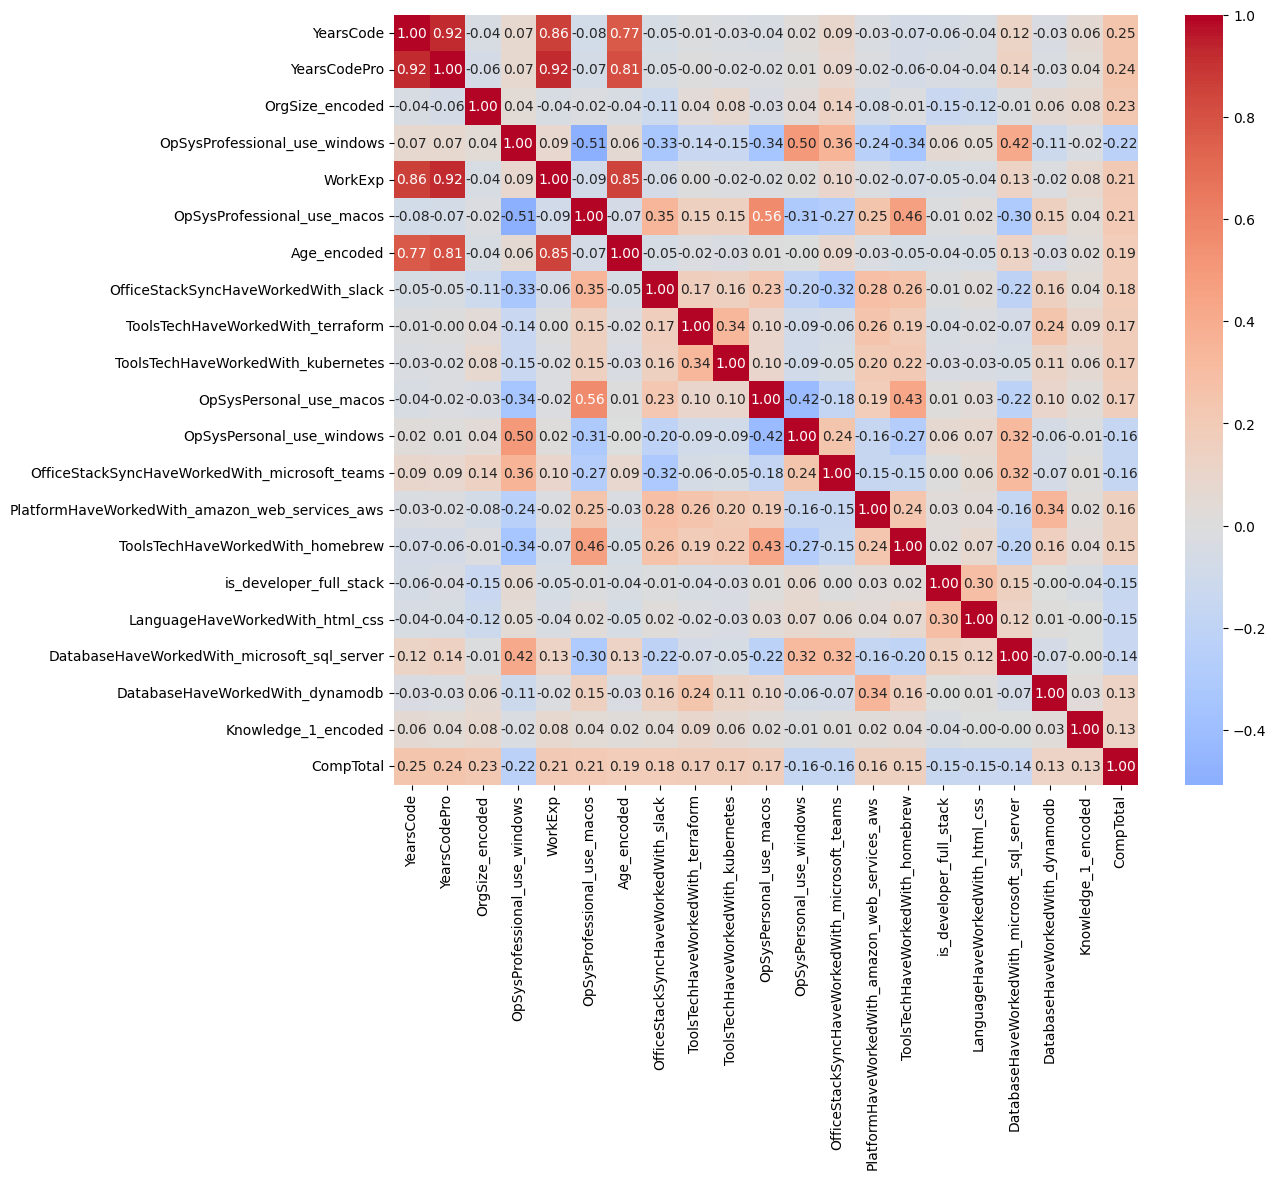

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top 20 feature names
top_features = correlations.head(20).index.tolist()

# Include the target for heatmap
top_features_with_target = top_features + ["CompTotal"]

# Compute correlation matrix
corr_matrix_top = df_stack[top_features_with_target].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_top, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title

**Observations**

Based on the heatmap above, we can see how different features relate to total compensation (`CompTotal`).

* A few features like `YearsCode`, `WorkExp`, `Age_encoded`, and `YearsCodePro` have moderate correlation with the target (around 0.20 to 0.30).
* No single feature strongly predicts salary on its own, and the signal seems to be spread across multiple features.
* Some features like `YearsCode`, `WorkExp`, and `YearsCodePro` are very similar to each other (correlated above 0.85), so we may only need one of them.
* Tools and platforms (like AWS or Slack) have weak individual relationships with target.

Since we don’t see any standout predictors here, we’ll explore better feature engineering, like interactions or non-linear combinations, in a separate notebook. Please refer to `AML2203_Final_Project_2025S_Modeling_Enhancement.ipynb`.

In [50]:
for col in df_stack.columns:
    print(col)

YearsCode
YearsCodePro
CompTotal
WorkExp
EdLevel_encoded
is_full_time
is_part_time
is_self_employed
is_retired
is_employment_unspecified
is_remote
is_hybrid
is_inperson
is_developer_full_stack
is_developer_back_end
is_developer_front_end
is_developer_desktop_or_enterprise_applications
is_engineering_manager
is_other_please_specify
is_developer_embedded_applications_or_devices
is_developer_mobile
is_cloud_infrastructure_engineer
is_data_scientist_or_machine_learning_specialist
OrgSize_encoded
num_languagehaveworkedwith
num_databasehaveworkedwith
num_platformhaveworkedwith
num_webframehaveworkedwith
num_misctechhaveworkedwith
num_toolstechhaveworkedwith
num_newcollabtoolshaveworkedwith
num_opsyspersonaluse
num_opsysprofessionaluse
num_officestackasynchaveworkedwith
num_officestacksynchaveworkedwith
num_aisearchhaveworkedwith
num_aitoolcurrentlyusing
num_learncodecoursescert
LanguageHaveWorkedWith_javascript
LanguageHaveWorkedWith_sql
LanguageHaveWorkedWith_html_css
LanguageHaveWorkedWith

## Prepare Baseline Feature Set for Modeling

This step we will drop unused columns and keep only the features needed for the baseline model.

In [51]:
# Choose the already encoded and numeric features
baseline_features = [
    "Age_encoded",
    "EdLevel_encoded",
    "YearsCodePro",
    "OrgSize_encoded",
    "WorkExp",
    "is_remote",
    "is_hybrid",
    "is_inperson"
]

# Drop rows with any missing values in these features
df_baseline = df_stack[baseline_features].dropna()

# Show result summary
print(" Final Baseline Dataset Shape:", df_baseline.shape)
print(df_baseline.head())

 Final Baseline Dataset Shape: (7647, 8)
   Age_encoded  EdLevel_encoded  YearsCodePro  OrgSize_encoded  WorkExp  \
0          2.0              4.0           9.0              1.0     10.0   
1          4.0              4.0          23.0              7.0     23.0   
2          2.0              4.0           7.0              4.0      7.0   
3          3.0              2.0           3.0              6.0      4.0   
4          2.0              4.0           3.0              2.0      5.0   

   is_remote  is_hybrid  is_inperson  
0          1          0            0  
1          0          1            0  
2          0          1            0  
3          1          0            0  
4          1          0            0  


In [52]:
# Target: Compensation

# Match target to baseline features
y = df_stack.loc[df_baseline.index, "CompTotal"]

# Final features from df_baseline
X = df_baseline.copy()

In [53]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (6117, 8)
Test shape: (1530, 8)


#  Baseline Regression with Raw Target (No Hyperparameter Tuning)

We'll use this for its robustness and minimal need for feature scaling.

For our baseline Random Forest regression model (using the raw CompTotal target), we selected a compact set of features that are:
* Numerical or ordinal (no further encoding required)
* Available early in the survey
* Likely to influence compensation based on domain knowledge and EDA

This baseline setup allows us to measure how much value is added when additional features (like tech stacks, developer roles, etc.) are incorporated later in the pipeline.

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [55]:
# Predict
y_pred = model.predict(X_test)

**Strategy**

After training the Random Forest model on the baseline feature set with the raw CompTotal target, we evaluated performance using three standard regression metrics
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* R² Score (Coefficient of Determination)

In [56]:
# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)

print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

MAE: 52807.79
RMSE: 72634.27
R² Score: 0.0361


**Interpretation**

* On average, the model’s salary predictions are off by about $53,000.
* A $72K error suggests that the model occasionally makes very large prediction errors, especially for high-salary earners, where it can under- or overestimate significantly.
* The model explains only about 7% of the variation in salaries.
That’s quite low, meaning other important factors (like job title, industry, or location) are probably missing from the data.
It shows that the model is not very reliable at capturing what drives compensation.

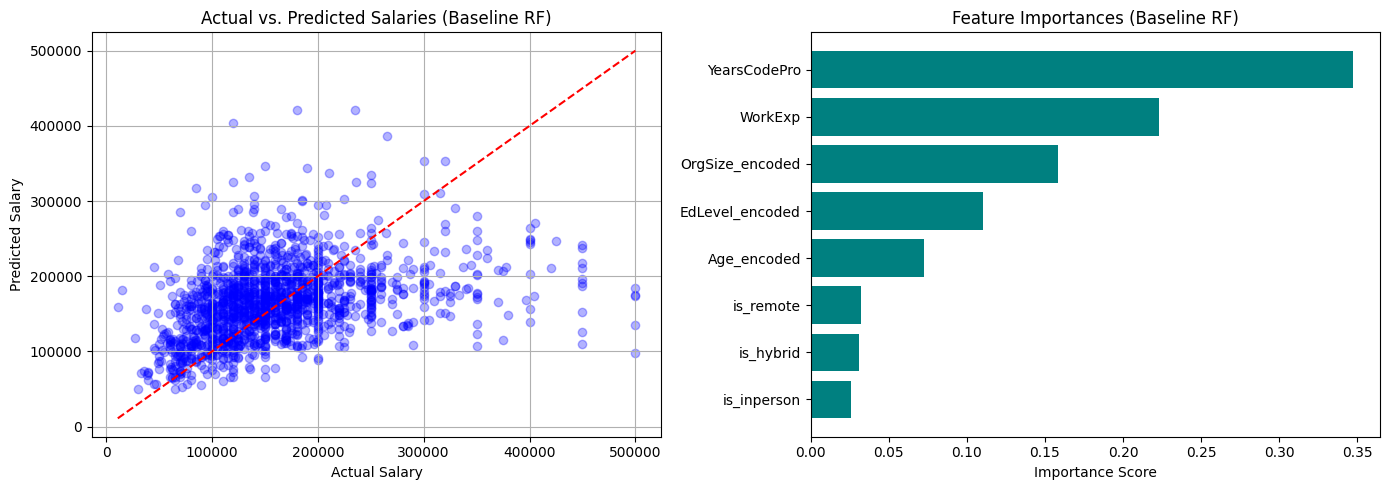

In [57]:
# Baseline Random Forest: Actual vs Predicted and Feature Importances
import matplotlib.pyplot as plt

# Actual vs Predicted
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (Baseline RF)")
plt.grid(True)

# Feature Importances
plt.subplot(1, 2, 2)
importances = model.feature_importances_
feature_names = X.columns
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Baseline RF)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Baseline RF Performance Summary:**

* The scatter plot shows that predictions follow the overall salary trend but get pulled toward the middle, especially at higher salary levels. The model misses high earners, which suggests our features aren’t capturing everything important.
* In the feature importance chart, `YearsCodePro` and `WorkExp` stand out the most, followed by `OrgSize_encoded` and `EdLevel_encoded`. Remote work flags like `is_remote` or `is_hybrid` don’t seem to matter much.
* This baseline gives a solid starting point, but it’s far from perfect. We’ll boost performance by adding better features and trying target transformations in the next steps.

# Hyperparameter Tuning for Random Forest (Same Baseline Feature)

**Strategy**

We tuned the Random Forest model using grid search across the following parameters:

* `n_estimators`: 100, 200
* `max_depth`: None, 10, 20
* `min_samples_split`: 2, 5
* `min_samples_leaf`: 1, 2
* `max_features`: 'sqrt', 'log2', or all

This setup let us test both simple and complex tree structures, balancing depth, leaf size, and feature selection to find the best configuration.

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define hyperparameter grid for Random Forest tuning
# Includes variations in tree count, depth, splitting rules, and feature selection strategy
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize base model
rf = RandomForestRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=2)

# Fit
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Use X_test not y_test
y_pred_best = best_rf.predict(X_test)

# Evaluation
mae_tuned = mean_absolute_error(y_test, y_pred_best)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_tuned = r2_score(y_test, y_pred_best)

print(f"Best Params: {grid_search.best_params_}")
print(f"MAE: {mae_tuned:.2f}")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"R² Score: {r2_tuned:.4f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 47662.42
RMSE: 65957.22
R² Score: 0.2052


**Interpretation**

* On average, the model’s salary predictions are off by around $48,000
* `RMSE: 65957.22` means the model still makes some large errors, especially for higher salaries.
* `R² Score: 0.2052` so the model explains about 20% of the variation in salaries using the input data.

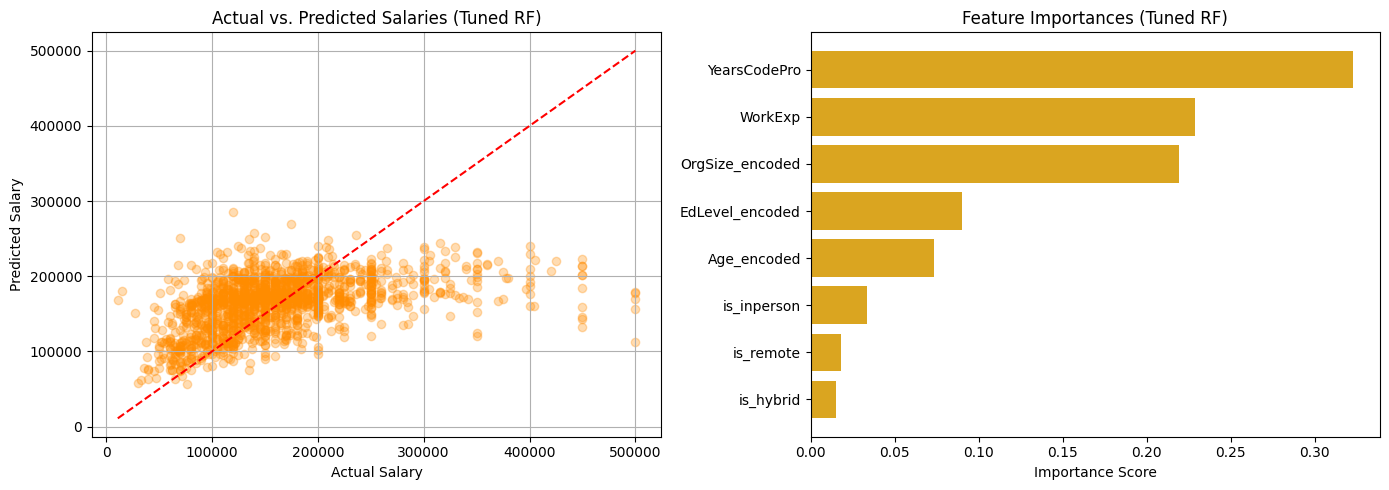

In [59]:
# Tuned Random Forest

# Actual vs Predicted

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_best, alpha=0.3, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (Tuned RF)")
plt.grid(True)

# Feature Importances

plt.subplot(1, 2, 2)
importances = best_rf.feature_importances_
feature_names = X_train.columns
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='goldenrod')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Tuned RF)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Interpretation**

* Most points are close to the red line, especially for lower and mid salaries. This means the model predicts average salaries fairly well. 

* But for higher salaries, the dots fall below the line, so the model underestimates top earners. 

* Overall, it captures the trend but misses on the high end. The most important feature was `YearsCodePro`, followed by `WorkExp` and `OrgSize_encoded`. 

* Education and age mattered a bit. Remote, hybrid, and in-person flags had little effect. This shows that experience and company size are more useful than work format when predicting salary.

# RandomForrest Regression with Logarithmic Transformation of Target (with Tuning)


**Strategy**

* The salary target variable is skewed, which affects model accuracy
* To fix this, we applied a log transformation using log1p on the salary column
* This reduces the impact of extreme outliers and makes the distribution more stable
* The model was trained and tuned using the log-transformed values
* After prediction, we converted the results back to the original scale using expm1
* This approach improves performance while keeping evaluation in real salary terms

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Set up features and log-transformed target
X = df_baseline.copy()
y = df_stack.loc[df_baseline.index, 'CompTotal']
y_log = np.log1p(y)  # log1p handles 0 or small values safely

# 2. Split into train/test
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# 3. Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# 4. GridSearchCV for hyperparameter tuning (on log-transformed target)
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train_log)

best_rf = grid_search.best_estimator_

# 5. Predict (log scale), then revert back using expm1
y_pred_log = best_rf.predict(X_test)
y_pred = np.expm1(y_pred_log)        # Inverse of log1p
y_test_actual = np.expm1(y_test_log) # Inverse of log1p

# 6. Evaluation
mae_log = mean_absolute_error(y_test_actual, y_pred)
rmse_log = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2_log = r2_score(y_test_actual, y_pred)

# 7. Output
print("Log-Transformed Target Evaluation (with Tuning):")
print("Best Params:", grid_search.best_params_)
print(f"MAE: {mae_log:,.2f}")
print(f"RMSE: {rmse_log:,.2f}")
print(f"R² Score: {r2_log:.4f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Log-Transformed Target Evaluation (with Tuning):
Best Params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 46,055.74
RMSE: 66,231.88
R² Score: 0.1985


**Interpretation**

* On average, predictions are off by about $46K

* The model still makes some big mistakes, especially for people on the high or low ends of the salary range.

* The model explains only 19% of what affects salary. That means 81% of the variation in salaries is due to other factors that the model didn’t capture (e.g., role, seniority, company, etc.).

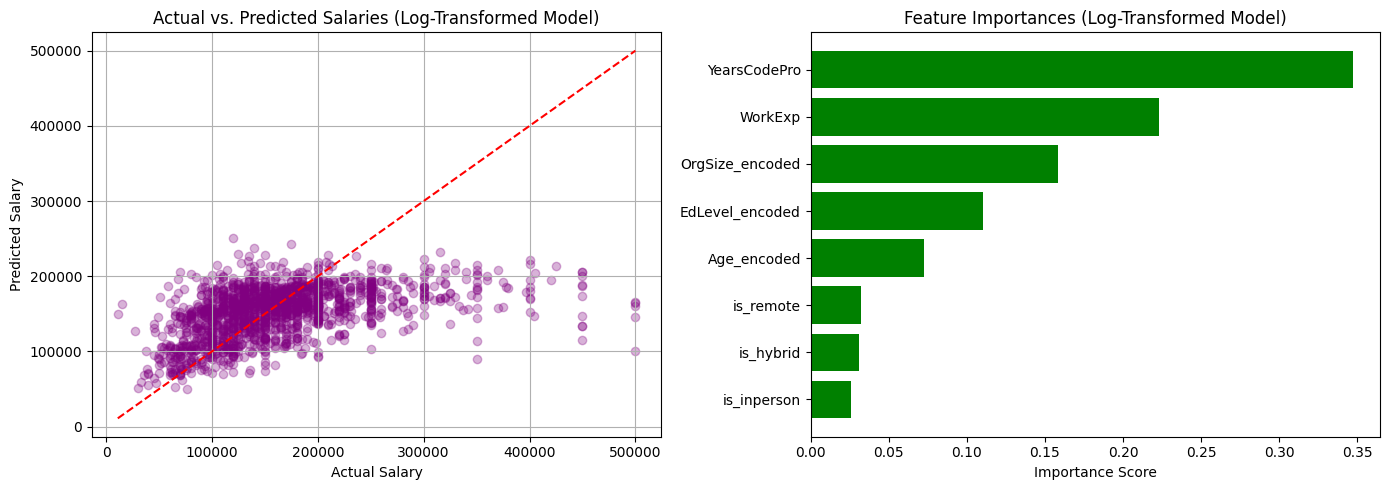

In [61]:
# Log-Transformed Model: Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_actual, y_pred, alpha=0.3, color='purple')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--', color='red')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (Log-Transformed Model)")
plt.grid(True)

#  Feature Importances
plt.subplot(1, 2, 2)
importances = model.feature_importances_
feature_names = X.columns
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='green')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Log-Transformed Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Observations**

* Predictions are more tightly grouped around the red line compared to the untransformed model
* Model performs well for mid-range salaries where points stay close to the ideal line
* Some underprediction remains for high salaries, but spread is more consistent overall
* Log transformation improved model stability and helped it handle salary variability
* `YearsCodePro` is the top feature, driving over 35% of predictive power
* `WorkExp` and `OrgSize_encoded` also have strong influence on salary
* Education and age have moderate impact
* Remote, hybrid, and in-person status add very little to prediction accuracy

# Feature Expansion with Tuning


### This is just a diagnostic step to check if there are missing enhanced features

**Strategy**

* We started with a tuned Random Forest model using a compact feature set.
* To improve performance, additional tech indicators were added.
* The focus was on top database tools like PostgreSQL, MySQL, MongoDB, SQLite, and Redis.
* We tuned the model using GridSearchCV to better capture salary patterns.
* The goal was to enhance prediction by introducing more relevant signals.

In [62]:
# Diagnostic: Check for missing enhanced features before modeling
enhanced_features = [
    'Age_encoded',
    'EdLevel_encoded',
    'YearsCodePro',
    'OrgSize_encoded',
    'WorkExp',
    'is_remote',
    'is_hybrid',
    'is_inperson',
    'is_full_time',
    'is_developer_full_stack',
    'LanguageHaveWorkedWith_python',
    # Database columns with correct names
    'DatabaseHaveWorkedWith_mysql',
    'DatabaseHaveWorkedWith_postgresql',
    'DatabaseHaveWorkedWith_microsoft_sql_server',
    'DatabaseHaveWorkedWith_sqlite',
    'DatabaseHaveWorkedWith_mongodb',
    'DatabaseHaveWorkedWith_redis',
    'DatabaseHaveWorkedWith_elasticsearch',
    'DatabaseHaveWorkedWith_mariadb',
    # Web framework columns
    'WebframeHaveWorkedWith_react',
    'WebframeHaveWorkedWith_nodejs',
    'WebframeHaveWorkedWith_jquery',
    'WebframeHaveWorkedWith_aspnet_core',
    'WebframeHaveWorkedWith_angular',
    'WebframeHaveWorkedWith_express',
    'WebframeHaveWorkedWith_nextjs',
    'WebframeHaveWorkedWith_vuejs',
    'WebframeHaveWorkedWith_flask',
    # Platform and tools
    'PlatformHaveWorkedWith_amazon_web_services_aws',
    'PlatformHaveWorkedWith_microsoft_azure',
    'PlatformHaveWorkedWith_google_cloud',
    'ToolsTechHaveWorkedWith_docker',
    'ToolsTechHaveWorkedWith_kubernetes'
 ]

missing_cols = [col for col in enhanced_features if col not in df_stack.columns]
if missing_cols:
    print('Missing columns:', missing_cols)
    print('All columns in df_stack:')
    print(df_stack.columns.tolist())
    print('Sample of df_stack:')
    display(df_stack.head())
else:
    print('All enhanced features are present!')

All enhanced features are present!


### Training The Model

In [63]:
# --- Enhanced Feature Set: Add three new features ---
enhanced_features = [
    'Age_encoded',
    'EdLevel_encoded',
    'YearsCodePro',
    'OrgSize_encoded',
    'WorkExp',
    'is_remote',
    'is_hybrid',
    'is_inperson',
    'is_full_time',
    'is_developer_full_stack',
    'LanguageHaveWorkedWith_python',

    # Top 10 most common databases used
    'DatabaseHaveWorkedWith_postgresql',
    'DatabaseHaveWorkedWith_mysql',
    'DatabaseHaveWorkedWith_microsoft_sql_server',
    'DatabaseHaveWorkedWith_sqlite',
    'DatabaseHaveWorkedWith_redis',
    'DatabaseHaveWorkedWith_mongodb',
    'DatabaseHaveWorkedWith_elasticsearch',
    'DatabaseHaveWorkedWith_mariadb'
]


# Ensure all features exist and drop rows with missing values
df_enhanced = df_stack.copy()
missing_cols = [col for col in enhanced_features if col not in df_enhanced.columns]
if missing_cols:
    print('Missing columns:', missing_cols)
    print('All columns in df_stack:')
    print(df_enhanced.columns.tolist())
    raise ValueError('Some required features are missing from the DataFrame. Please check the feature engineering steps above.')

df_enhanced = df_enhanced[enhanced_features + ['CompTotal']].dropna()

# Features and target
X_enhanced = df_enhanced[enhanced_features]
y_enhanced = df_enhanced['CompTotal']

# Train/test split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_rf.predict(X_test)
mae_exp = mean_absolute_error(y_test, y_pred)
rmse_exp = mean_squared_error(y_test, y_pred) ** 0.5  # Fix: remove 'squared' argument
r2_exp = r2_score(y_test, y_pred)

print('Best Params:', grid_search.best_params_)
print(f'MAE: {mae_exp:,.2f}')
print(f'RMSE: {rmse_exp:,.2f}')
print(f'R² Score: {r2_exp:.4f}')

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MAE: 44,702.47
RMSE: 62,722.40
R² Score: 0.2812


**Interpretation**

* On average, the model's predictions are off by more than $44K

* RMSE: 62,722.40 shows that the model still struggles especially with very high or very low salaries.

* The model can explain about 28% of the salary differences between developers. That means it’s picking up on some important factors, but most of what affects salary is still not captured.

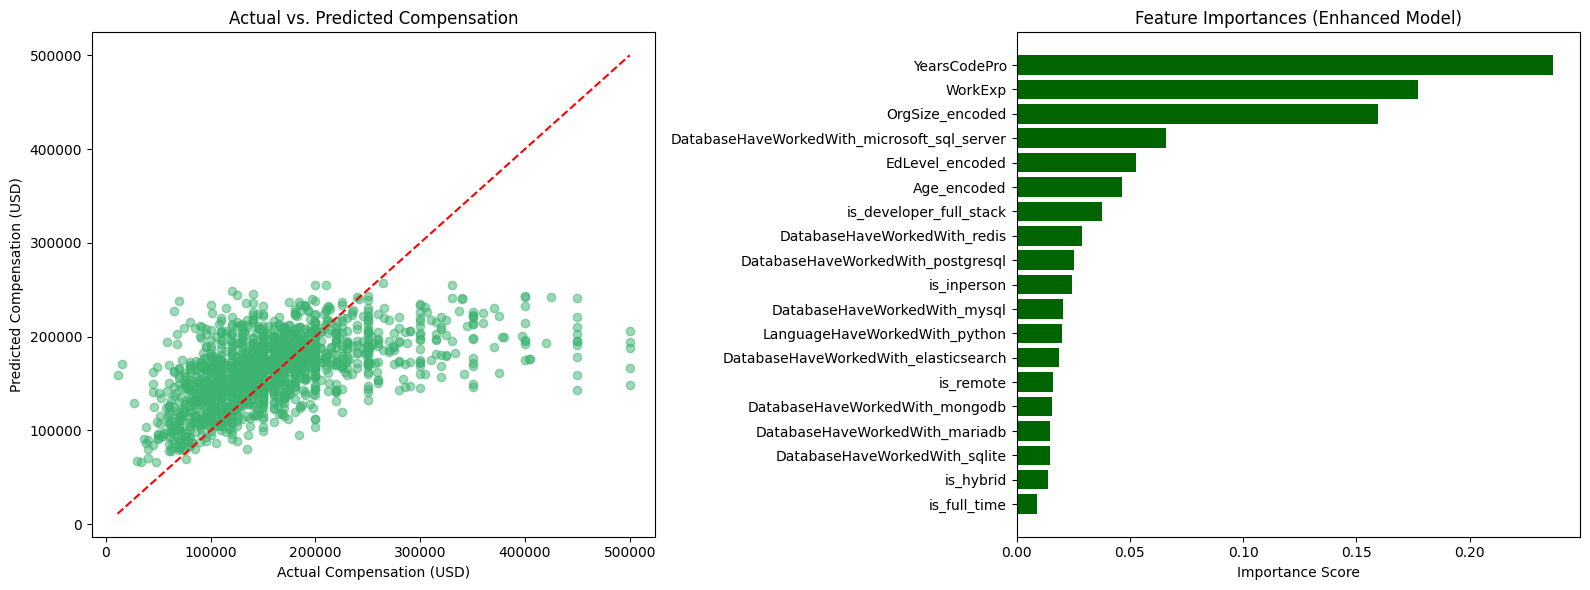

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Feature Importances ---
importances = best_rf.feature_importances_
feat_names = X_enhanced.columns

# Create a DataFrame sorted by importance
feat_imp_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: Actual vs. Predicted Scatter Plot
axes[0].scatter(y_test, y_pred, alpha=0.5, color='mediumseagreen')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Compensation (USD)')
axes[0].set_ylabel('Predicted Compensation (USD)')
axes[0].set_title('Actual vs. Predicted Compensation')

#  Right Plot: Feature Importances
axes[1].barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='darkgreen')
axes[1].invert_yaxis()  # Highest importance at the top
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Feature Importances (Enhanced Model)')

# Final layout adjustments
plt.tight_layout()
plt.show()

**Interpretation:**
* The model performs well for mid-range salaries but tends to underpredict high earners, especially above $300K. 

* Log transformation and feature expansion improved prediction consistency. 

* Years of coding experience, total work experience, and company size were the strongest predictors. 

* Some technologies and roles added moderate value, while work format and lesser-used tools had little impact.

# Gradient Boosting


**Strategy**

* Gradient Boosting Regressor (GBR) was applied to further improve prediction accuracy.
* Built on the same enhanced feature set combining demographics, technical tools, and employment type.
* As an ensemble method, GBR builds trees sequentially, correcting previous errors at each step.
* Especially effective for capturing complex, non-linear patterns in structured survey data.
* Offers a more refined alternative to baseline models by learning subtle interactions across features.

In [65]:
#  Gradient Boosting Regressor: Train and Evaluate on Enhanced Features

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the model
gbr_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr_model.fit(X_train, y_train)

# Predict on test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate model performance
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = mean_squared_error(y_test, y_pred_gbr) ** 0.5
r2_gbr = r2_score(y_test, y_pred_gbr)

# Print results
print('Gradient Boosting Results:')
print(f'MAE: {mae_gbr:,.2f}')
print(f'RMSE: {rmse_gbr:,.2f}')
print(f'R² Score: {r2_gbr:.4f}')

Gradient Boosting Results:
MAE: 44,496.89
RMSE: 62,320.92
R² Score: 0.2904


**Interpretation**

* On average, the model’s salary predictions are off by around $44K, which is a moderate error given the wide range of tech salaries.

* `RMSE: 62,320.92` shows that while many predictions are close, there are still some larger errors, especially for very high or very low salaries.

* The model explains about 29% of the differences in developer salaries. This is an improvement over earlier models, suggesting the added features helped the model better understand what affects compensation

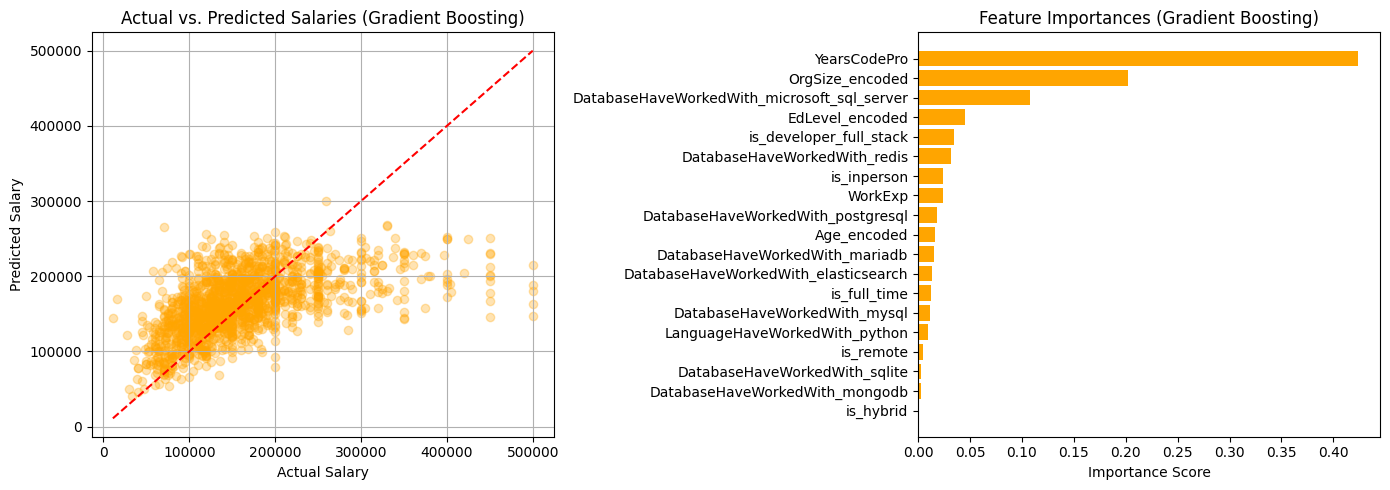

In [66]:
# Gradient Boosting:

# Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gbr, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (Gradient Boosting)")
plt.grid(True)

# Feature Importances
plt.subplot(1, 2, 2)
importances = gbr_model.feature_importances_
feature_names = X_train.columns
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='orange')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Gradient Boosting)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Observations**
* Most predictions fall below the red line, indicating consistent underestimation, especially at higher salary levels.
* Best performance is seen in the mid-range salary bracket (\$100k–\$200k), where predictions are closer to actual values.
* Underprediction increases for high salaries (above \$250k), likely due to higher variance and fewer training examples.
* `YearsCodePro` is the strongest predictor, showing that coding experience heavily influences salary.
* `OrgSize_encoded`, `EdLevel_encoded`, and experience with Microsoft SQL Server also have noticeable impact.
* Full-stack roles and tools like Redis and DynamoDB contribute moderately.
* Work format indicators and rarely used databases show minimal influence on predictions.

# Overall Table Comparison

In [67]:
import pandas as pd

# 1. Gather all results in a list of dictionaries
results = [
    {
        "Model": "Baseline Random Forest",
        "MAE": mae_rf,
        "RMSE": rmse_rf,
        "R2": r2_rf
    },
    {
        "Model": "Hyperparameter Tuning for Random Forest",
        "MAE": mae_tuned,
        "RMSE": rmse_tuned,
        "R2": r2_tuned
    },
    {
        "Model": "Random Forest with Log-Transformed Target",
        "MAE": mae_log,
        "RMSE": rmse_log,
        "R2": r2_log
    },
    {
        "Model": "Feature Expansion with Tuning",
        "MAE": mae_exp,
        "RMSE": rmse_exp,
        "R2": r2_exp
    },
    {
        "Model": "Gradient Boosting",
        "MAE": mae_gbr,
        "RMSE": rmse_gbr,
        "R2": r2_gbr
    }
]

# 2. Create a DataFrame for a clean table
results_df = pd.DataFrame(results)

# 3. Format for readability (optional)
results_df["MAE"] = results_df["MAE"].apply(lambda x: f"${x:,.2f}")
results_df["RMSE"] = results_df["RMSE"].apply(lambda x: f"${x:,.2f}")
results_df["R2"] = results_df["R2"].apply(lambda x: f"{x:.4f}")

# 4. Display the table
print(results_df)


                                       Model         MAE        RMSE      R2
0                     Baseline Random Forest  $52,807.79  $72,634.27  0.0361
1    Hyperparameter Tuning for Random Forest  $47,662.42  $65,957.22  0.2052
2  Random Forest with Log-Transformed Target  $46,055.74  $66,231.88  0.1985
3              Feature Expansion with Tuning  $44,702.47  $62,722.40  0.2812
4                          Gradient Boosting  $44,496.89  $62,320.92  0.2904


**Summary**

* Gradient Boosting delivered the best overall performance across all models tested.
* Achieved lowest errors (MAE: ~$44K, RMSE: ~$62K) and highest R² (0.2904), explaining nearly 30% of salary variation.
* Feature Expansion using Random Forest with Tuning closely followed (R²: 0.2812), showing the value of including database and developer-type features.
* Log-transformed Random Forest model (with tuning) performed moderately (R²: 0.1985) but was outpaced by models with richer features.
* The baseline Random Forest showed poor performance (R²: 0.0361), confirming that feature limitations hold back accuracy.
* Even tuning alone (without feature expansion) led to notable improvement (R²: 0.2052), highlighting the impact of hyperparameter optimization.
* Overall, both feature engineering and model tuning played key roles in improving salary prediction results.

# Export encoded dataset for Further Enhancement

In [68]:
df_stack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11139 entries, 0 to 11340
Columns: 207 entries, YearsCode to Frequency_3_is_missing
dtypes: float64(7), int64(200)
memory usage: 17.9 MB


In [69]:
df_stack.to_csv("stack_overflow_encoded.csv", index=False)